In [2]:
# Single-cell RNA-seq Analysis using Scanpy
### Dataset: PBMC 3k (10x Genomics)

This notebook performs a complete single-cell RNA-seq analysis workflow using Scanpy.
The pipeline includes quality control, filtering, doublet detection, normalization, dimensionality reduction, clustering, visualization, and marker gene identification.


## Download dataset

The PBMC 3k dataset is downloaded from 10x Genomics.
This dataset contains approximately 3,000 peripheral blood mononuclear cells and is commonly used as a benchmark dataset in single-cell RNA-seq analysis.

# download dataset (external 10x)
!wget -O pbmc3k.tar.gz \
https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz

--2026-02-22 14:39:38--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘pbmc3k.tar.gz’

pbmc3k.tar.gz       100%[===================>]   7.27M  --.-KB/s    in 0.08s   

2026-02-22 14:39:39 (87.4 MB/s) - ‘pbmc3k.tar.gz’ saved [7621991/7621991]



In [3]:
import tarfile

with tarfile.open("pbmc3k.tar.gz", "r:gz") as tar:
    tar.extractall("data")

/tmp/ipython-input-1126691092.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("data")


In [1]:
## Load dataset into AnnData object

The expression matrix is loaded and converted into an AnnData object, which is the core data structure used by Scanpy for storing single-cell data.

import scanpy as sc

adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",
    var_names="gene_symbols",
    cache=True
)

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [2]:
##  Basic preprocessing

Initial preprocessing includes making gene names unique and creating metadata required for downstream quality control.

adata.obs["sample"] = "PBMC3k_external"
adata.obs["condition"] = "healthy"

In [3]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

In [4]:
##  Quality control metrics

Quality control metrics such as number of genes per cell, total counts per cell, and mitochondrial gene percentage are calculated to assess cell quality.

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo"],
    percent_top=None,
    log1p=False,
    inplace=True
)

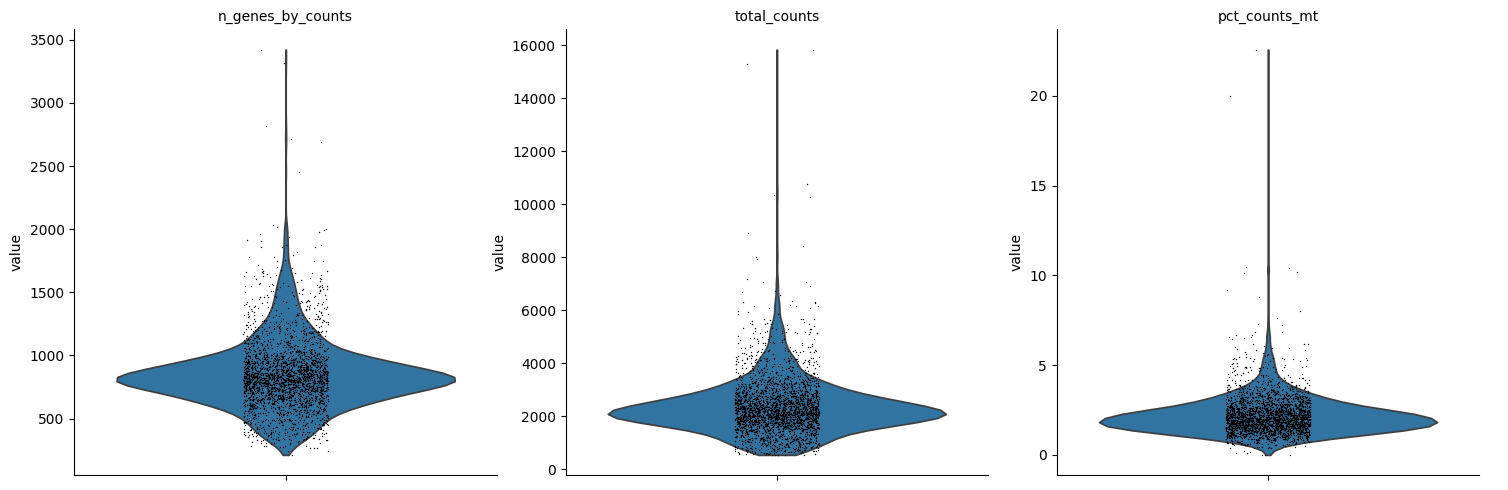

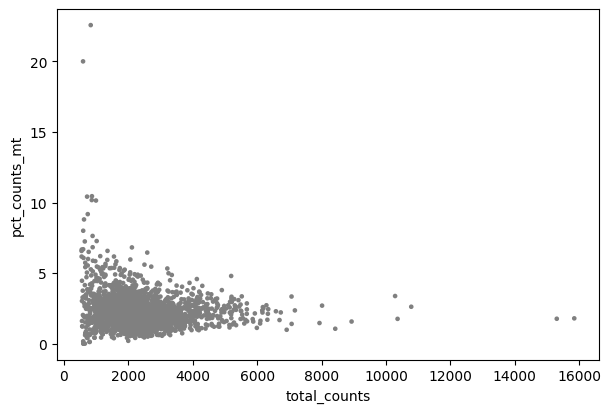

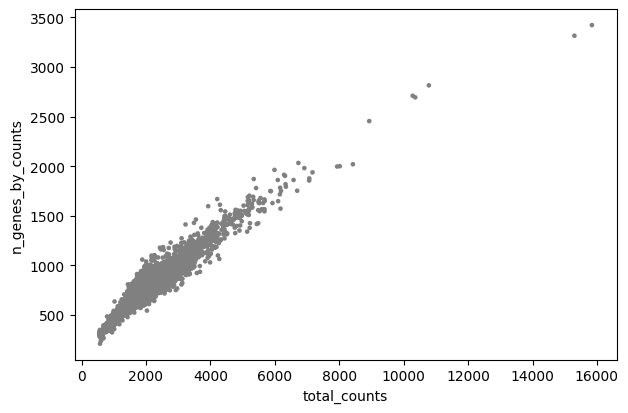

In [5]:
##  Quality control visualization

Visualizations are generated to inspect data quality and determine filtering thresholds.

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    multi_panel=True
)

sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [6]:
## Cell filtering
Low-quality cells and potential outliers are removed based on quality control thresholds.


adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

sc.pp.filter_genes(adata, min_cells=3)

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:278: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [7]:
##  Doublet detection (Scrublet)
Scrublet is used to identify and remove doublets, which occur when two cells are captured as one during sequencing.

import scrublet as scr

counts_matrix = adata.X

scrub = scr.Scrublet(counts_matrix)
doublet_scores, predicted_doublets = scrub.scrub_doublets()

adata.obs["doublet_score"] = doublet_scores
adata.obs["predicted_doublet"] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 43.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.5%
Elapsed time: 8.9 seconds


In [8]:
adata = adata[~adata.obs["predicted_doublet"], :]

In [9]:
## Normalization and log transformation
Counts are normalized per cell to make cells comparable, followed by log transformation to stabilize variance.

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/tmp/ipython-input-3052528762.py:1: UserWarning: Received a view of an AnnData. Making a copy.
  sc.pp.normalize_total(adata, target_sum=1e4)


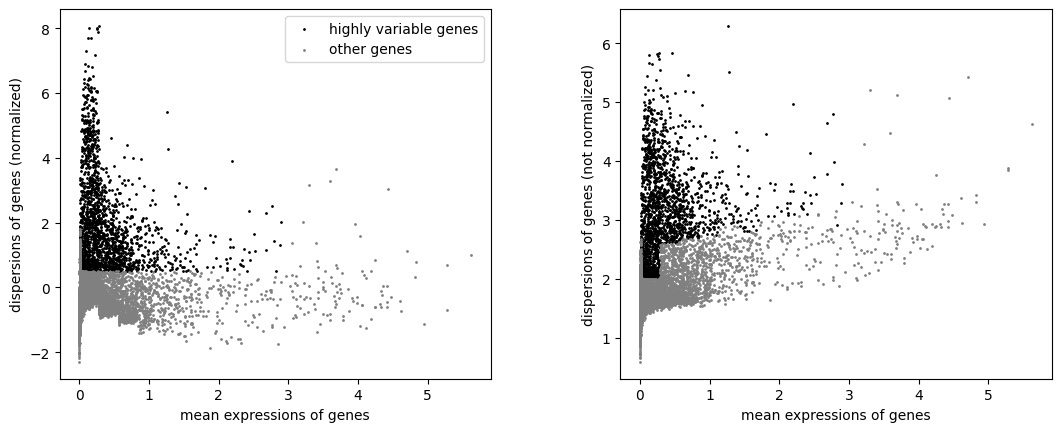

In [10]:
## Highly variable gene selection
Highly variable genes are identified since they capture most biological variation and improve downstream analysis.


sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5
)

sc.pl.highly_variable_genes(adata)

adata = adata[:, adata.var.highly_variable]

In [11]:
##  Data scaling
Data is scaled to ensure genes contribute equally to downstream dimensionality reduction.

sc.pp.scale(adata, max_value=10)

/usr/lib/python3.12/functools.py:912: UserWarning: Received a view of an AnnData. Making a copy.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


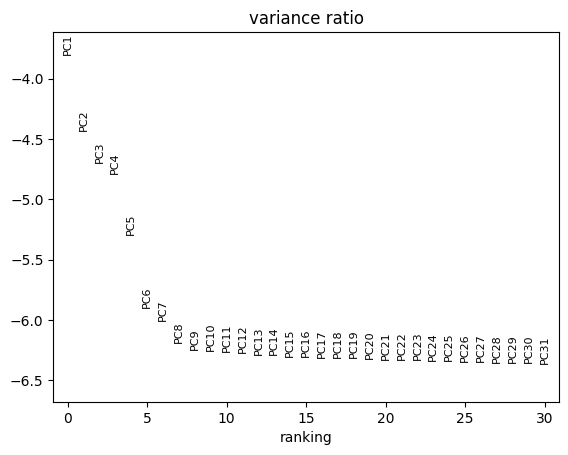

In [12]:
## Principal component analysis (PCA)
PCA reduces dimensionality and captures major sources of variation in the dataset.

sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)

In [13]:
## Neighborhood graph construction
A nearest-neighbor graph is computed to represent cell similarity, which is required for clustering and UMAP.

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [15]:
!pip install leidenalg igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 72.7 MB/s eta 0:00:00


In [16]:
## Clustering using Leiden algorithm
Cells are grouped into clusters representing potential cell populations.

sc.tl.leiden(adata, resolution=0.5)

/tmp/ipython-input-1771924308.py:1: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, resolution=0.5)


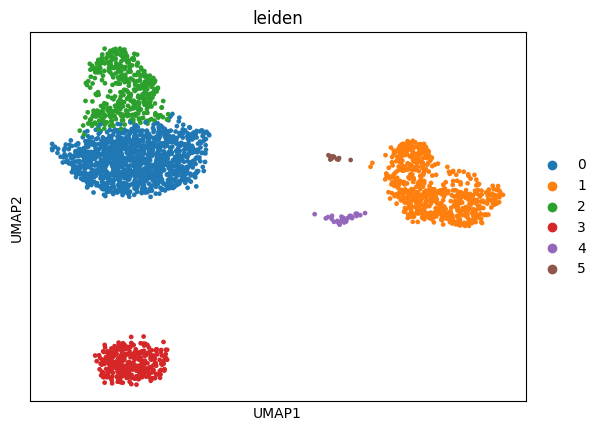

In [17]:
## UMAP visualization
UMAP projects cells into two dimensions to visualize cell populations and clustering structure.

sc.tl.umap(adata)

sc.pl.umap(adata, color=["leiden"])

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:483: 

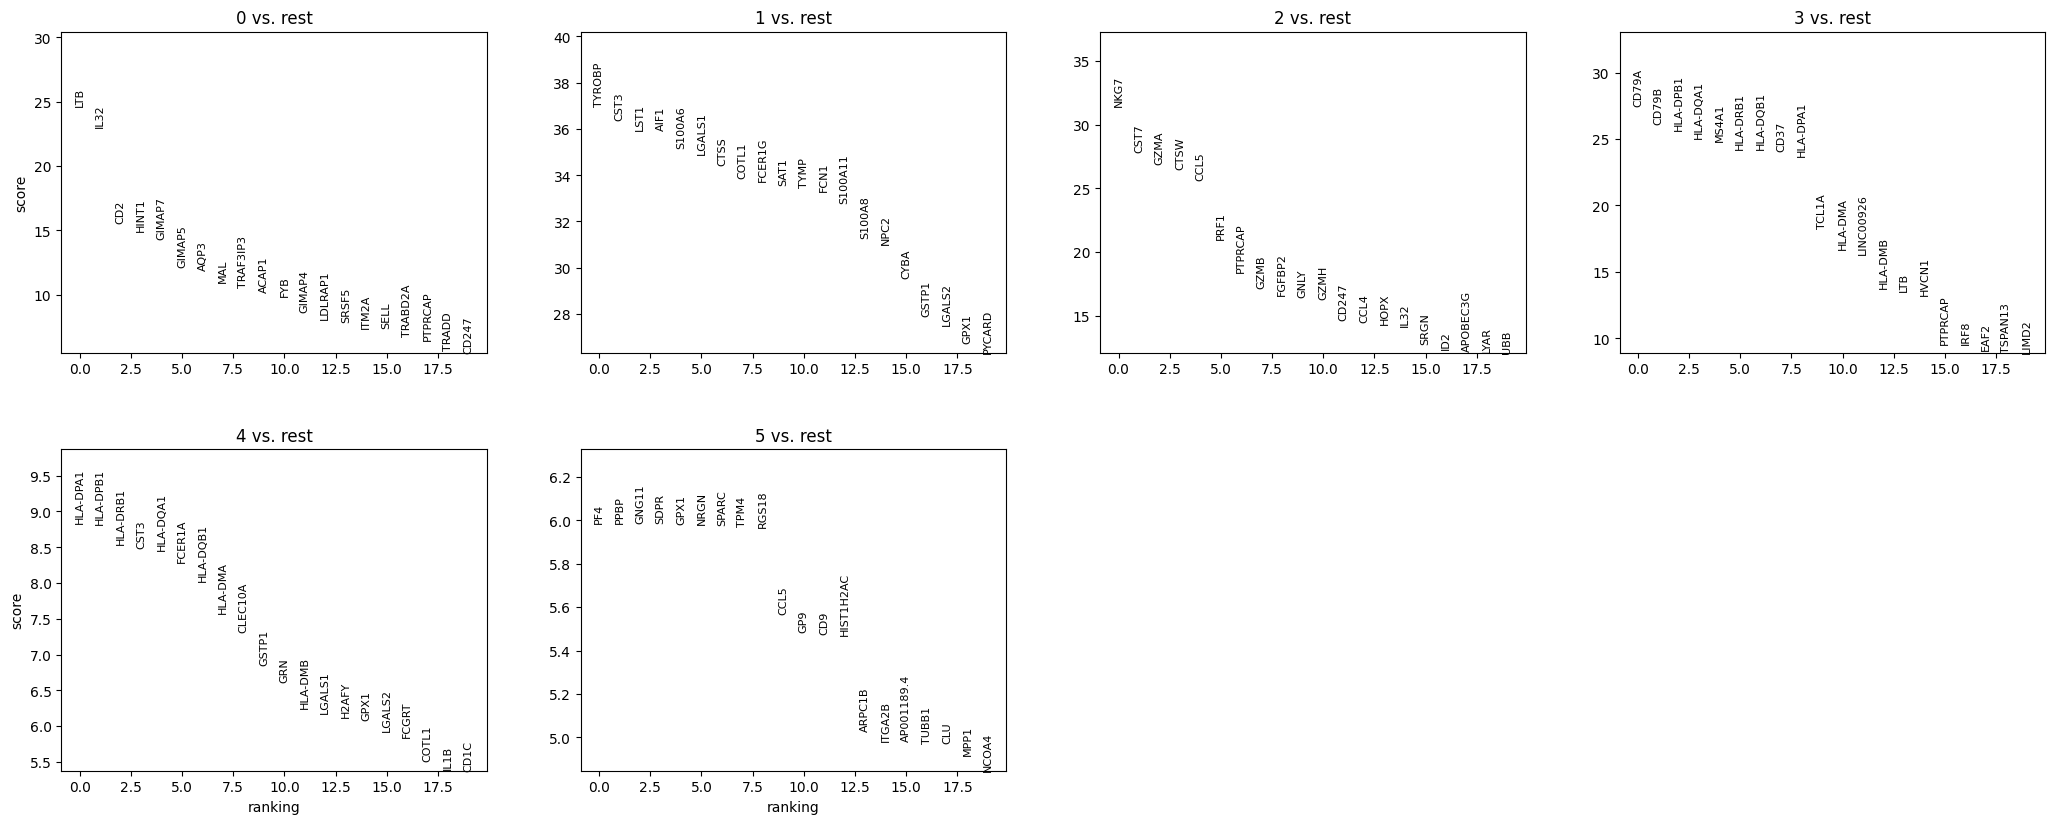

In [18]:
##  Marker gene identification
Differential expression analysis is performed to identify marker genes for each cluster.

sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [19]:
## Save processed data
The processed AnnData object is saved for downstream analysis and reproducibility.


adata.write("pbmc3k_external_processed.h5ad")

In [21]:
adata.write("pbmc3k_processed.h5ad")